In [1]:
import numpy as np

## Model

We want to control a linear motion, driven by a stepper motor.
The rotational movement of the stepper motor is translated into a translatory movement by means of a threaded rod.
Given a number of stepper steps $n$ the translation $x$ can be determined using

$x = m \cdot n$.

$m$ is the transmission ratio.
Dividing both sides by $\Delta t$, which represents the time interval it took to accomplish the movement, yields

$v = m \cdot f_\mathrm{stepper}$.

This equation relates the velocity $v = \partial x / \partial t$ with the step frequency $f_\mathrm{stepper}$.
A quick research shows, that often a trapezoidal velocity profile is used.
Thereby, we get an acceleration phase, a steady phase, and a deacceleration phase.
During acceleration, the velocity follows

$v_\mathrm{set} (t) = a_\mathrm{set} \cdot t $

We can calculate the necessary stepper frequency to accomplish that velocity using

$f_\mathrm{stepper} = v_\mathrm{set} / m$

Pulses in that frequency are generated using the PWM module of our Atmega328 microcontroller in TBD mode.
The microcontroller is running at clock speed $f_\mathrm{clk}$.
A prescaler in the timer module allows to adapt this frequency by division using one of the predefined prescaler $p$ values 8, 32, 64, 128, 256, or 1024.
We configure the timer module to increment its counter with that frequency $f_\mathrm{timer}$ and restart from zero when a specific value $k$ between 1 and 256 is reached.
Simultaneously, an interrupt is triggered, which can be used to initiate the stepper pulse and update the reset value $k$.
A second timer started, finishing the stepper pulse at expiration.

$f_\mathrm{stepper} = \frac{f_\mathrm{clk}}{k \cdot p}$

The reset count $k$ is what we need to calculate, so we end up with

$k(t) = f_\mathrm{clk} / \left( f_\mathrm{stepper} \cdot p \right) = m \cdot f_\mathrm{clk} / \left( a  \cdot p \cdot t \right)$

We need k for specific times, not continuously, and call these values $k_0 = k(t_0)$, $k_1 = k(t_1)$, and so on.
These times are defined as follows 

$t_i = t_0 + \sum_{j=0}^{i-1} T_j$, with $t_0 = 0$ and $T_j = 1 / f_\mathrm{stepper}(t_j)= 1 / f_{\mathrm{stepper},j}$


## Parameters

In [2]:
# Transmission ratio m
m = 3 / 8 / 4500

# acceleration and deacceleration set point
a = 30

# velocity set point
v_set = 10

# position set point
x_set = 15

# clock frequency (atmega)
f_clk = 16e6 / 8

# counter with (8bit)
n_cnt = 256

## Movement Planning

### Acceleration phase - Variant 1 - Iterative

Working good with floats, not so good with integers on Atmega microcontroller :(

In [14]:
k = (256-1)

f_s = []

movement_plan_acceleration = [
    [k, 1]
]

# 
f = f_clk / k
t = 0.0

f_s.append(f)

while (m * f_clk / movement_plan_acceleration[-1][0]) < v_set:
    
    Δt = 1/f
    
    t += Δt

    f = f +  a / m / f

    f_s.append(f)

    k = np.round(f_clk / f)

    if k == movement_plan_acceleration[-1][0] and movement_plan_acceleration[-1][1] < 256:
        movement_plan_acceleration[-1][1] += 1
    else:
        movement_plan_acceleration.append([k, 1])

###  Acceleration phase - Variant 2: Global definition

works with floats and integers (below)

In [15]:
k = 256

f_s = []

movement_plan_acceleration = [
    [k, 1]
]

# 
f = f_clk / k
k_sum = k
t_0 = m * f_clk / ( a * k)

f_s.append(f)

while (m * f_clk / movement_plan_acceleration[-1][0]) < v_set:

    k = np.round(f_clk * m / ( a * (t_0 + k_sum/f_clk)))

    k_sum += k
    
    if k == movement_plan_acceleration[-1][0] and movement_plan_acceleration[-1][1] < 256:
        movement_plan_acceleration[-1][1] += 1
    else:
        movement_plan_acceleration.append([k, 1])

In [18]:
k = 256

f_s = []

movement_plan_acceleration = [
    [k, 1]
]

# 
f_clk100 = np.uint16(np.round(f_clk / 100))
k_sum = np.uint32(k)
t_0 =  m * f_clk / ( a * k)

while (m * f_clk / movement_plan_acceleration[-1][0]) < v_set:

    tmp = np.uint32(55555) / np.uint32((10* 1000*t_0) + (10*k_sum/(f_clk/1000)))
    k = np.uint16(tmp) #np.uint16(tmp)

    k_sum += k
    
    if k == movement_plan_acceleration[-1][0] and movement_plan_acceleration[-1][1] < 256:
        movement_plan_acceleration[-1][1] += 1
    else:
        movement_plan_acceleration.append([k, 1])

In [52]:
len(movement_plan_acceleration)

284

### Steady Phase

In [37]:

len_acc_part = len(movement_plan_acceleration)
x_acc = m * sum((movement[1] for movement in movement_plan_acceleration))

steps_steady_left = (x_set - 2 * x_acc) // m
n_steady = movement_plan_acceleration[-1][0]

movement_plan_steady = [
    [n_steady, 1]
]

while steps_steady_left > 0:

    if n_steady == movement_plan_steady[-1][0] and movement_plan_steady[-1][1] < 256:
        movement_plan_steady[-1][1] += 1
    else:
        movement_plan_steady.append([n_steady, 1])
    
    steps_steady_left -= 1

In [38]:
len(movement_plan_steady)

551

In [43]:
len_acc_part = len(movement_plan_acceleration)
x_acc = m * sum((movement[1] for movement in movement_plan_acceleration))

steps_steady_left = (x_set - 2 * x_acc) // m
n_steady = movement_plan_acceleration[-1][0]

movement_plan_steady = int(steps_steady_left//256) * [(n_steady, 256)] + [(n_steady, int(steps_steady_left%256))]

In [44]:
len(movement_plan_steady)

551

### Deacceleration

In [64]:
movement_plan_deaccleration = [
    [n_steady, 1]
]

k_sum_before = k_sum
while True:

    tmp = m * f_clk / ( v_set - a * (k_sum-k_sum_before)/f_clk)
    k = np.uint16(tmp)

    if k > 256:
        break
    
    k_sum += k
    
    if k == movement_plan_deaccleration[-1][0] and movement_plan_deaccleration[-1][1] < 256:
        movement_plan_deaccleration[-1][1] += 1
    else:
        movement_plan_deaccleration.append([k, 1])

In [65]:
len(movement_plan_deaccleration)

290

In [62]:
movement_plan_deaccleration = [
    [n_steady, 1]
]

k_sum_before = k_sum
while True:

    tmp = np.uint16(100 * m * f_clk) / ((np.uint16(100 *  v_set) -  np.uint16(a) * np.uint32((k_sum-k_sum_before) / 100)/np.uint16(f_clk/10000)))
    k = np.uint16(tmp)

    if k > 256:
        break
    
    k_sum += k
    
    if k == movement_plan_deaccleration[-1][0] and movement_plan_deaccleration[-1][1] < 256:
        movement_plan_deaccleration[-1][1] += 1
    else:
        movement_plan_deaccleration.append([k, 1])

In [ ]:
def calc_deaccel(k_sum_deaccel):
    tmp = np.uint16(100 * m * f_clk) / (np.uint16(100 *  v_set) -  np.uint16(a) * np.uint32((k_sum_deaccel/ 100)/np.uint16(f_clk/10000)))
    k = np.uint16(tmp)

In [69]:
a / f_clk * 1e7

150.0

In [66]:
len(movement_plan_deaccleration)

290

### Combine all phases

In [46]:
movement_plan = movement_plan_acceleration + movement_plan_steady + movement_plan_deaccleration

## Display Movement

In [47]:
steps = sum([cnt*[n] for n, cnt in movement_plan], [])

In [48]:
len(steps)

180824

In [49]:
t_s = []
v_s = []
x_s = []

x = 0
t = 0

for n in steps:
    T = n / f_clk
    t += T
    x += m

    t_s.append(t)
    v_s.append(m/T)
    x_s.append(x)

In [50]:
from matplotlib import pyplot as plt

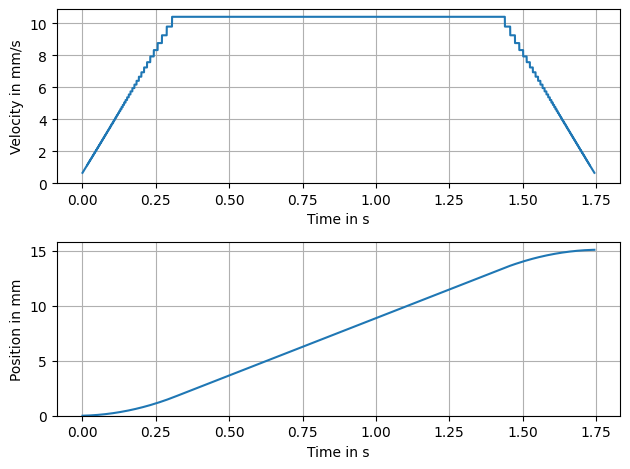

In [51]:
fig, [ax1, ax2] =  plt.subplots(2,1)

ax1.plot(t_s, v_s)

ax1.set_ylim((0,None))

ax1.set_xlabel("Time in s")
ax1.set_ylabel("Velocity in mm/s")
ax1.grid()

ax2.plot(t_s, x_s)

ax2.set_ylim((0,None))

ax2.set_xlabel("Time in s")
ax2.set_ylabel("Position in mm")
ax2.grid()

plt.tight_layout()

In [74]:
np.diff(t_s).min(), np.max(t_s), np.log(np.max(t_s)*1e6)

(7.999999999896978e-06, 1.7465220000012005, 14.37313693977219)

In [18]:
np.log(len(steps))
np.log(len(steps))

12.102122246301802